<a href="https://colab.research.google.com/github/sashapff/recommender_systems/blob/main/recsys_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Матричные факторизации

В данной работе вам предстоит познакомиться с практической стороной матричных разложений.
Работа поделена на 4 задания:
1. Вам необходимо реализовать SVD разложения используя SGD на explicit данных
2. Вам необходимо реализовать матричное разложения используя ALS на implicit данных
3. Вам необходимо реализовать матричное разложения используя BPR(pair-wise loss) на implicit данных
4. Вам необходимо реализовать матричное разложения используя WARP(list-wise loss) на implicit данных


In [ ]:
!pip install implicit
!pip install lightfm

In [ ]:
import implicit
import pandas as pd
import numpy as np
import scipy.sparse as sp

from lightfm.datasets import fetch_movielens

from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


В данной работе мы будем работать с explicit датасетом movieLens, в котором представленны пары user_id movie_id и rating выставленный пользователем фильму

Скачать датасет можно по ссылке https://grouplens.org/datasets/movielens/1m/

In [ ]:
prefix = '/content/drive/My Drive/recsys/ml-1m/'

In [ ]:
ratings = pd.read_csv(prefix + 'ratings.dat', delimiter='::', header=None, 
        names=['user_id', 'movie_id', 'rating', 'timestamp'], 
        usecols=['user_id', 'movie_id', 'rating'], engine='python')

In [ ]:
movie_info = pd.read_csv(prefix + 'movies.dat', delimiter='::', header=None, 
        names=['movie_id', 'name', 'category'], engine='python')

Explicit данные

In [ ]:
ratings.head(10)

,user_id,movie_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
5,1,1197,3
6,1,1287,5
7,1,2804,5
8,1,594,4
9,1,919,4


Для того, чтобы преобразовать текущий датасет в Implicit, давайте считать что позитивная оценка это оценка >=4

In [ ]:
implicit_ratings = ratings.loc[(ratings['rating'] >= 4)]

In [ ]:
implicit_ratings.head(10)

,user_id,movie_id,rating
0,1,1193,5
3,1,3408,4
4,1,2355,5
6,1,1287,5
7,1,2804,5
8,1,594,4
9,1,919,4
10,1,595,5
11,1,938,4
12,1,2398,4


Удобнее работать с sparse матричками, давайте преобразуем DataFrame в CSR матрицы

In [ ]:
users = implicit_ratings["user_id"]
movies = implicit_ratings["movie_id"]
user_item = sp.coo_matrix((np.ones_like(users), (users, movies)))
user_item_t_csr = user_item.T.tocsr()
user_item_csr = user_item.tocsr()

В качестве примера воспользуемся ALS разложением из библиотеки implicit

Зададим размерность латентного пространства равным 64, это же определяет размер user/item эмбедингов

In [ ]:
model = implicit.als.AlternatingLeastSquares(factors=64, iterations=100, calculate_training_loss=True)

В качестве loss здесь всеми любимый RMSE

In [ ]:
model.fit(user_item_t_csr)

Построим похожие фильмы по 1 movie_id = Истории игрушек

In [ ]:
movie_info.head(5)

In [ ]:
get_similars = lambda item_id, model : [movie_info[movie_info["movie_id"] == x[0]]["name"].to_string() 
                                        for x in model.similar_items(item_id)]

Как мы видим, симилары действительно оказались симиларами.

Качество симиларов часто является хорошим способом проверить качество алгоритмов.

P.S. Если хочется поглубже разобраться в том как разные алгоритмы формируют разные латентные пространства, рекомендую загружать полученные вектора в tensorBoard и смотреть на сформированное пространство

In [ ]:
get_similars(1, model)

Давайте теперь построим рекомендации для юзеров

Как мы видим юзеру нравится фантастика, значит и в рекомендациях ожидаем увидеть фантастику

In [ ]:
get_user_history = lambda user_id, implicit_ratings : [movie_info[movie_info["movie_id"] == x]["name"].to_string() 
                                            for x in implicit_ratings[implicit_ratings["user_id"] == user_id]["movie_id"]]

In [ ]:
get_user_history(4, implicit_ratings)

Получилось! 

Мы действительно порекомендовали пользователю фантастику и боевики, более того встречаются продолжения тех фильмов, которые он высоко оценил

In [ ]:
get_recommendations = lambda user_id, model : [movie_info[movie_info["movie_id"] == x[0]]["name"].to_string() 
                                               for x in model.recommend(user_id, user_item_csr)]

In [ ]:
get_recommendations(4, model)

Теперь ваша очередь реализовать самые популярные алгоритмы матричных разложений

Что будет оцениваться:
1. Корректность алгоритма
2. Качество получившихся симиларов
3. Качество итоговых рекомендаций для юзера

In [ ]:
import random
import matplotlib.pyplot as plt
import math

In [ ]:
class MatrixFactorization():
    def similar_items(self, item_id):
        return sorted([(id, np.linalg.norm(self.H[:, id] - self.H[:, item_id])) for id in self.items], key=lambda x: x[1]) 

    def recommend(self, user_id, user_item_csr):
        # не удаляем из рекоммендаций уже просмотренные фильмы, 
        # лучше это сделать уже после вызова функции get_recommendations
        # потому что просмотренные фильмы в аутпуте реккомендаций говорят о том, что модель хорошо обучилась
        return sorted(list(zip(self.items, (self.W @ self.H)[user_id][self.items])), key=lambda x: x[1], reverse=True)

### Задание 1. Не использую готовые решения, реализовать SVD разложение используя SGD на explicit данных

In [ ]:
class SVD(MatrixFactorization):
    def fit(self, ratings, k=64, regularization_lambda=1e-2, learning_rate=1e-2, steps=5000000):
        self.users = ratings['user_id'].unique()
        self.items = ratings['movie_id'].unique()
        users_number = max(self.users) + 1
        items_number = max(self.items) + 1
        W = np.random.random((users_number, k)) / (k ** 0.5)
        H = np.random.random((k, items_number)) / (k ** 0.5)
        rmse = []
        rmse_steps = []
        for step in range(steps):
            rating_index = random.randint(0, ratings.shape[0] - 1)
            row = ratings.iloc[[rating_index]]
            i = row['user_id']
            j = row['movie_id']
            error = W[i] @ H[:, j] - row['rating'].to_numpy()[0]
            W[i] -= learning_rate * (error * H[:, j].T + regularization_lambda * W[i])
            H[:, j] -= learning_rate * (error * W[i].T + regularization_lambda * H[:, j])
            if step % (steps // 100) == 0:
                rmse_value = np.linalg.norm((W @ H)[ratings['user_id'], ratings['movie_id']] - ratings['rating']) / (ratings.shape[0] ** 0.5)
                rmse_steps.append(step)
                rmse.append(rmse_value)
            if step % (steps // 100) == 0:
                print(f"RMSE: {rmse_value}, step number: {step}")
        self.W = W
        self.H = H
        return W, H, rmse, rmse_steps

In [ ]:
svd = SVD()
W, H, rmse, rmse_steps = svd.fit(ratings)

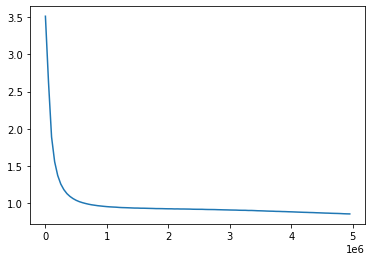

In [ ]:
plt.plot(rmse_steps, rmse) # RMSE

In [ ]:
get_similars(1, svd)[:15]

['0    Toy Story (1995)',
 '3045    Toy Story 2 (1999)',
 '591    Beauty and the Beast (1991)',
 '2011    Lady and the Tramp (1955)',
 '2012    Little Mermaid, The (1989)',
 "2286    Bug's Life, A (1998)",
 '360    Lion King, The (1994)',
 '1009    Cinderella (1950)',
 '584    Aladdin (1992)',
 '2728    Big (1988)',
 "941    It's a Wonderful Life (1946)",
 '1628    Witness (1985)',
 '1015    Mary Poppins (1964)',
 '2571    Superman (1978)',
 '1878    West Side Story (1961)']

In [ ]:
get_user_history(4, implicit_ratings)

['3399    Hustler, The (1961)',
 '2882    Fistful of Dollars, A (1964)',
 '1196    Alien (1979)',
 '1023    Die Hard (1988)',
 '257    Star Wars: Episode IV - A New Hope (1977)',
 '1959    Saving Private Ryan (1998)',
 '476    Jurassic Park (1993)',
 '1180    Raiders of the Lost Ark (1981)',
 '1885    Rocky (1976)',
 '1081    E.T. the Extra-Terrestrial (1982)',
 '3349    Thelma & Louise (1991)',
 '3633    Mad Max (1979)',
 '2297    King Kong (1933)',
 '1366    Jaws (1975)',
 '1183    Good, The Bad and The Ugly, The (1966)',
 '2623    Run Lola Run (Lola rennt) (1998)',
 '2878    Goldfinger (1964)',
 '1220    Terminator, The (1984)']

In [ ]:
get_recommendations(4, svd)[:15]

['2836    Sanjuro (1962)',
 '1132    Wrong Trousers, The (1993)',
 '910    Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)',
 '2961    Yojimbo (1961)',
 '1950    Seven Samurai (The Magnificent Seven) (Shichin...',
 '315    Shawshank Redemption, The (1994)',
 '2953    General, The (1927)',
 '735    Close Shave, A (1995)',
 '3238    City Lights (1931)',
 '1185    12 Angry Men (1957)',
 '847    Godfather, The (1972)',
 '2693    Sixth Sense, The (1999)',
 '711    Wallace & Gromit: The Best of Aardman Animatio...',
 "523    Schindler's List (1993)",
 '740    Dr. Strangelove or: How I Learned to Stop Worr...']

### Задание 2. Не использую готовые решения, реализовать матричное разложение используя ALS на implicit данных

In [ ]:
class ALS(MatrixFactorization):
    def fit(self, user_item_csr, k=64, regularization_lambda=1e-2, learning_rate=1e-2, steps=100, alpha=2):
        self.users = np.unique(sp.coo_matrix(user_item_csr).row)
        self.items = np.unique(sp.coo_matrix(user_item_csr).col)
        users_number = max(self.users) + 1
        items_number = max(self.items) + 1
        W = np.random.random((users_number, k)) / (k ** 0.5)
        H = np.random.random((k, items_number)) / (k ** 0.5)
        rmse = []
        rmse_steps = []
        I_u = np.eye(users_number)
        I_i = np.eye(items_number)
        implicit_ratings = np.array(user_item_csr.toarray())
        for step in range(steps):
            if step % 2 == 1:
                H = (np.linalg.inv(W @ W.T + regularization_lambda * I_u) @ W).T @ implicit_ratings
            else:
                W = implicit_ratings @ (np.linalg.inv(H.T @ H + regularization_lambda * I_i) @ H.T)
            rmse_value = np.linalg.norm((W @ H) - user_item_csr) / ((user_item_csr.shape[0] * user_item_csr.shape[1]) ** 0.5)
            rmse_steps.append(step)
            rmse.append(rmse_value)
            print(f"RMSE: {rmse_value}, step number: {step}")
        self.W = W
        self.H = H
        return W, H, rmse, rmse_steps

In [ ]:
als = ALS()
W, H, rmse, rmse_steps = als.fit(user_item_csr, steps=20)

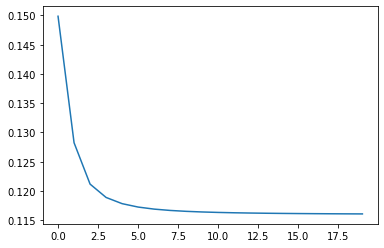

In [ ]:
plt.plot(rmse_steps, rmse) # RMSE

Не использую версию алгоритма с матрицами уверенности, так как и без нее довольно неплохо работает

In [ ]:
get_similars(1, als)[:15]

['0    Toy Story (1995)',
 '3045    Toy Story 2 (1999)',
 "2286    Bug's Life, A (1998)",
 '584    Aladdin (1992)',
 '360    Lion King, The (1994)',
 '2252    Pleasantville (1998)',
 '591    Beauty and the Beast (1991)',
 '2225    Antz (1998)',
 '1838    Mulan (1998)',
 '33    Babe (1995)',
 '1720    Wedding Singer, The (1998)',
 '2692    Iron Giant, The (1999)',
 '2618    Tarzan (1999)',
 '1468    Grosse Pointe Blank (1997)',
 '1029    That Thing You Do! (1996)']

In [ ]:
get_user_history(4, implicit_ratings)

['3399    Hustler, The (1961)',
 '2882    Fistful of Dollars, A (1964)',
 '1196    Alien (1979)',
 '1023    Die Hard (1988)',
 '257    Star Wars: Episode IV - A New Hope (1977)',
 '1959    Saving Private Ryan (1998)',
 '476    Jurassic Park (1993)',
 '1180    Raiders of the Lost Ark (1981)',
 '1885    Rocky (1976)',
 '1081    E.T. the Extra-Terrestrial (1982)',
 '3349    Thelma & Louise (1991)',
 '3633    Mad Max (1979)',
 '2297    King Kong (1933)',
 '1366    Jaws (1975)',
 '1183    Good, The Bad and The Ugly, The (1966)',
 '2623    Run Lola Run (Lola rennt) (1998)',
 '2878    Goldfinger (1964)',
 '1220    Terminator, The (1984)']

In [ ]:
get_recommendations(4, als)[:20]

['1180    Raiders of the Lost Ark (1981)',
 '1366    Jaws (1975)',
 '257    Star Wars: Episode IV - A New Hope (1977)',
 '1196    Alien (1979)',
 '1220    Terminator, The (1984)',
 '1959    Saving Private Ryan (1998)',
 '1081    E.T. the Extra-Terrestrial (1982)',
 '585    Terminator 2: Judgment Day (1991)',
 '1023    Die Hard (1988)',
 '1271    Indiana Jones and the Last Crusade (1989)',
 '2878    Goldfinger (1964)',
 '1885    Rocky (1976)',
 '1284    Butch Cassidy and the Sundance Kid (1969)',
 '2502    Matrix, The (1999)',
 '1183    Good, The Bad and The Ugly, The (1966)',
 '1182    Aliens (1986)',
 '1178    Star Wars: Episode V - The Empire Strikes Back...',
 '476    Jurassic Park (1993)',
 '3402    Close Encounters of the Third Kind (1977)',
 '453    Fugitive, The (1993)']

### Задание 3. Не использую готовые решения, реализовать матричное разложение BPR на implicit данных

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
class BPR(MatrixFactorization):
    def fit(self, user_item_csr, implicit_ratings, k=64, regularization_lambda=1e-4, learning_rate=1e-2, steps=10):
        self.users = np.unique(sp.coo_matrix(user_item_csr).row)
        self.items = np.unique(sp.coo_matrix(user_item_csr).col)
        users_number = max(self.users) + 1
        items_number = max(self.items) + 1
        W = np.random.random((users_number, k)) / (k ** 0.5)
        H = np.random.random((k, items_number)) / (k ** 0.5)
        auc = []
        auc_steps = []

        def sigma(x):
            return (math.e ** (-x)) / (1 + math.e ** (-x))

        for step in range(steps):
            auc_sum = 0
            for index, row in tqdm(implicit_ratings.iterrows()):
                u = row['user_id']
                i = row['movie_id']
                while True:
                    j = random.randint(1, items_number - 1)
                    if user_item_csr[u, j] == 0:
                        break
                dx = W[u] @ H[:, i] - W[u] @ H[:, j]
                sigma_dx = sigma(dx)
                W[u] += learning_rate * (sigma_dx * (H[:, i] - H[:, j]) + regularization_lambda * W[u])
                H[:, i] += learning_rate * (sigma_dx * W[u] + regularization_lambda * H[:, i]) 
                H[:, j] += learning_rate * (sigma_dx * (-W[u]) + regularization_lambda * H[:, j]) 
                if W[u] @ H[:, i] > W[u] @ H[:, j]:
                    auc_sum += 1
            auc_value = auc_sum / implicit_ratings.shape[0]
            auc.append(auc_value)
            auc_steps.append(step)
            print(f"AUC: {auc_value}, step number: {step}")
        self.W = W
        self.H = H
        return W, H, auc, auc_steps


In [ ]:
bpr = BPR()
W, H, auc, auc_steps = bpr.fit(user_item_csr, implicit_ratings)

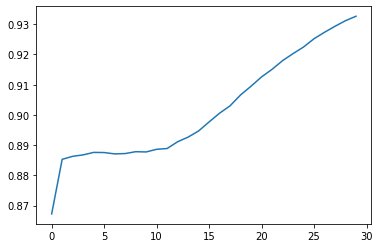

In [ ]:
plt.plot(auc_steps, auc) # AUC

Можно было бы еще пообучать, но уж очень много времени одна эпоха занимает, с таким значением AUC уже хорошо выдает рекомендации

In [ ]:
get_similars(1, bpr)[:15]

['0    Toy Story (1995)',
 "2286    Bug's Life, A (1998)",
 '3045    Toy Story 2 (1999)',
 '1179    Princess Bride, The (1987)',
 '1250    Back to the Future (1985)',
 '1245    Groundhog Day (1993)',
 '584    Aladdin (1992)',
 '2918    Who Framed Roger Rabbit? (1988)',
 '2647    Ghostbusters (1984)',
 '1058    Willy Wonka and the Chocolate Factory (1971)',
 "2849    Ferris Bueller's Day Off (1986)",
 '1899    Breakfast Club, The (1985)',
 '1192    Star Wars: Episode VI - Return of the Jedi (1983)',
 '1271    Indiana Jones and the Last Crusade (1989)',
 '2728    Big (1988)']

In [ ]:
get_user_history(4, implicit_ratings)

['3399    Hustler, The (1961)',
 '2882    Fistful of Dollars, A (1964)',
 '1196    Alien (1979)',
 '1023    Die Hard (1988)',
 '257    Star Wars: Episode IV - A New Hope (1977)',
 '1959    Saving Private Ryan (1998)',
 '476    Jurassic Park (1993)',
 '1180    Raiders of the Lost Ark (1981)',
 '1885    Rocky (1976)',
 '1081    E.T. the Extra-Terrestrial (1982)',
 '3349    Thelma & Louise (1991)',
 '3633    Mad Max (1979)',
 '2297    King Kong (1933)',
 '1366    Jaws (1975)',
 '1183    Good, The Bad and The Ugly, The (1966)',
 '2623    Run Lola Run (Lola rennt) (1998)',
 '2878    Goldfinger (1964)',
 '1220    Terminator, The (1984)']

In [ ]:
get_recommendations(4, bpr)[:20]

['2789    American Beauty (1999)',
 '257    Star Wars: Episode IV - A New Hope (1977)',
 '1178    Star Wars: Episode V - The Empire Strikes Back...',
 '589    Silence of the Lambs, The (1991)',
 '1180    Raiders of the Lost Ark (1981)',
 '1959    Saving Private Ryan (1998)',
 '2693    Sixth Sense, The (1999)',
 '2502    Matrix, The (1999)',
 '1250    Back to the Future (1985)',
 '1192    Star Wars: Episode VI - Return of the Jedi (1983)',
 "523    Schindler's List (1993)",
 '604    Fargo (1996)',
 '585    Terminator 2: Judgment Day (1991)',
 '847    Godfather, The (1972)',
 '315    Shawshank Redemption, The (1994)',
 '1575    L.A. Confidential (1997)',
 '2327    Shakespeare in Love (1998)',
 '293    Pulp Fiction (1994)',
 '108    Braveheart (1995)',
 '2928    Being John Malkovich (1999)']

### Задание 4. Не использую готовые решения, реализовать матричное разложение WARP на implicit данных

In [ ]:
class WARP(MatrixFactorization):
    def fit(self, user_item_csr, implicit_ratings, k=64, regularization_lambda=1e-2, learning_rate=1e-2, steps=5, sampling_size=10):
        self.users = np.unique(sp.coo_matrix(user_item_csr).row)
        self.items = np.unique(sp.coo_matrix(user_item_csr).col)
        users_number = max(self.users) + 1
        items_number = max(self.items) + 1
        W = np.random.random((users_number, k)) / (k ** 0.5)
        H = np.random.random((k, items_number)) / (k ** 0.5)
        auc = []
        auc_steps = []

        def sigma(x):
            return (math.e ** (-x)) / (1 + math.e ** (-x))

        for step in range(steps):
            auc_sum = 0
            for index, row in tqdm(implicit_ratings.iterrows()):
                u = row['user_id']
                i = row['movie_id']
                for _ in range(sampling_size):
                    while True:
                        j = random.randint(1, items_number - 1)
                        if user_item_csr[u, j] == 0:
                            break
                    dx = W[u] @ H[:, i] - W[u] @ H[:, j]
                    if dx < 0:
                        sigma_dx = sigma(dx)
                        W[u] += learning_rate * (sigma_dx * (H[:, i] - H[:, j]) + regularization_lambda * W[u])
                        H[:, i] += learning_rate * (sigma_dx * W[u] + regularization_lambda * H[:, i]) 
                        H[:, j] += learning_rate * (sigma_dx * (-W[u]) + regularization_lambda * H[:, j]) 
                    if W[u] @ H[:, i] > W[u] @ H[:, j]:
                        auc_sum += 1
            auc_value = auc_sum / (implicit_ratings.shape[0] * sampling_size)
            auc.append(auc_value)
            auc_steps.append(step)
            print(f"AUC: {auc_value}, step number: {step}")
        self.W = W
        self.H = H
        return W, H, auc, auc_steps


In [ ]:
warp = WARP()
W, H, auc, auc_steps = warp.fit(user_item_csr, implicit_ratings, steps=5)

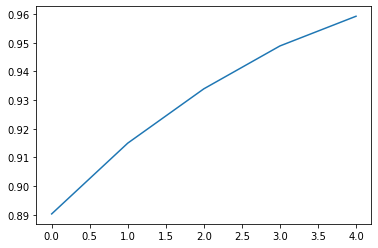

In [ ]:
plt.plot(auc_steps, auc) # AUC

Аналогичная ситуация, что можно пообучать подольше, но работает нереально долго. В похожих фильмах в топе есть продолжение Истории Игрушек, что является хорошим критерием, что алгоритм хоть как-то работает. Остальные странные фильмы просто из-за недообучения. В рекомендациях юзеру есть аж 3 части Звездных войн!

In [ ]:
get_similars(1, warp)[:15]

['0    Toy Story (1995)',
 '2693    Sixth Sense, The (1999)',
 '1245    Groundhog Day (1993)',
 '1250    Back to the Future (1985)',
 '1179    Princess Bride, The (1987)',
 '1178    Star Wars: Episode V - The Empire Strikes Back...',
 '3045    Toy Story 2 (1999)',
 '585    Terminator 2: Judgment Day (1991)',
 '257    Star Wars: Episode IV - A New Hope (1977)',
 '1192    Star Wars: Episode VI - Return of the Jedi (1983)',
 '2647    Ghostbusters (1984)',
 '33    Babe (1995)',
 '1180    Raiders of the Lost Ark (1981)',
 '1539    Men in Black (1997)',
 '2327    Shakespeare in Love (1998)']

In [ ]:
get_user_history(4, implicit_ratings)

['3399    Hustler, The (1961)',
 '2882    Fistful of Dollars, A (1964)',
 '1196    Alien (1979)',
 '1023    Die Hard (1988)',
 '257    Star Wars: Episode IV - A New Hope (1977)',
 '1959    Saving Private Ryan (1998)',
 '476    Jurassic Park (1993)',
 '1180    Raiders of the Lost Ark (1981)',
 '1885    Rocky (1976)',
 '1081    E.T. the Extra-Terrestrial (1982)',
 '3349    Thelma & Louise (1991)',
 '3633    Mad Max (1979)',
 '2297    King Kong (1933)',
 '1366    Jaws (1975)',
 '1183    Good, The Bad and The Ugly, The (1966)',
 '2623    Run Lola Run (Lola rennt) (1998)',
 '2878    Goldfinger (1964)',
 '1220    Terminator, The (1984)']

In [ ]:
get_recommendations(4, warp)[:20]

['2012    Little Mermaid, The (1989)',
 '2655    Runaway Bride (1999)',
 '1023    Die Hard (1988)',
 '1081    E.T. the Extra-Terrestrial (1982)',
 '257    Star Wars: Episode IV - A New Hope (1977)',
 '325    Star Trek: Generations (1994)',
 '1192    Star Wars: Episode VI - Return of the Jedi (1983)',
 '2992    Holiday Inn (1942)',
 '2664    Vibes (1988)',
 '996    Escape to Witch Mountain (1975)',
 '1220    Terminator, The (1984)',
 '1353    Star Trek: The Wrath of Khan (1982)',
 '1312    Believers, The (1987)',
 '2882    Fistful of Dollars, A (1964)',
 '1178    Star Wars: Episode V - The Empire Strikes Back...',
 '3483    Caddyshack (1980)',
 '3150    Pacific Heights (1990)',
 '583    Ghost (1990)',
 '1491    Fifth Element, The (1997)',
 '2803    Excalibur (1981)']